<a href="https://colab.research.google.com/github/tatsath/PortfolioOptimization/blob/main/BareBonesAnalysis/Step0_MultipleTimeSteps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import numpy.matlib
from scipy.stats import norm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import seaborn as sns

In [3]:
# # %%
# params ={ "mu": 0.1,
#          "sigma": 0.2,
#          "T" : 1}

#%% ANN
class MyNet(nn.Module):
    
    def __init__(self, n ):
        super(MyNet, self).__init__()
        
        # 1 input layer (X_T^delta), 1 output channel, 3 hidden layers with n units each
        self.f_in_to_h1 = nn.Linear( 2 , n)
        self.f_h1_to_h2 = nn.Linear(n, n)
        self.f_h2_to_out = nn.Linear(n, 1)
        #self.f_h2_to_out = nn.LogSoftmax(n, 3)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        
        # input into 1st hidden layer
        h1 = self.myReLU(self.f_in_to_h1(x) )
        
        # 1st hidden to 2nd hidden layer
        h2 = self.myReLU(self.f_h1_to_h2(h1))
            
        # 2nd hidden layer to output layer
        y = self.f_h2_to_out(h2)      
        
        return y
    

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
print(device)    

cuda


In [5]:
params = {
    "S0" : np.array([1]),
    "mu" : np.array([0.03]),
    "sigma" : np.array([.2]),
    "rho" : np.array([[1]]),
    "rf" : 0.00,
    "delta" : np.array([0.7]),
    "T" : 5
    }


def SimPath(Ndt, params, T, Nsims):
    
    dt = T/Ndt
    
    N_assets= params["mu"].shape[0]
    
    assert N_assets == params["sigma"].shape[0], "#assets in mu != #assets in sigma"
    assert N_assets == params["rho"].shape[0], "#assets in mu != #assets in rho"
    assert params["rho"].ndim == 2, "rho must be matrix"
    assert N_assets == params["rho"].shape[1], "rho not square matrix"
    
    S = np.zeros((Ndt+1, Nsims, N_assets ))
    S[0,:,:] = params["S0"]

    
    for i in range(Ndt):
        
        dW = np.sqrt(dt) * np.random.multivariate_normal(np.zeros(N_assets), params["rho"], Nsims)
        S[i+1,:,:] = S[i,:,:] * np.exp((params["mu"]-0.5*params["sigma"]**2)*dt + params["sigma"]*dW)
        
    t = np.linspace(0,T,Ndt+1)
    return t, S

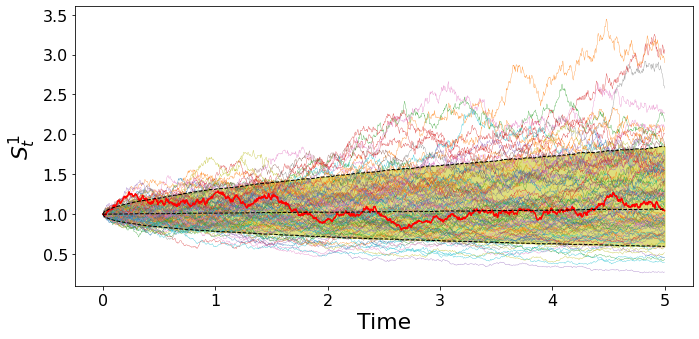

In [6]:
# Sim some paths and show sims with quantiles and a sample path
t, S = SimPath(Ndt=252*5, params = params, T=5, Nsims = 10000)

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 16})
plt.rc('axes', labelsize=22)
for i in range(S.shape[2]):
    
    plt.subplot(1,S.shape[2],i+1)
    
    plt.fill_between(t, np.quantile(S[:,:,i],0.1,axis=1).T, np.quantile(S[:,:,i],0.9,axis=1).T, color='y', alpha=0.5)
    plt.plot(t, S[:,:100,i],linewidth=0.3)
    plt.plot(t, S[:,0,i],color='r',linewidth=1.5)
    plt.plot(t, np.quantile(S[:,:,i],[0.1, 0.5, 0.9],axis=1).T,color='k',linewidth=1, linestyle='--')
    
    plt.xlabel("Time")
    plt.ylabel("$S_t^" +str(i+1)+"$")
    
plt.tight_layout()
plt.show()

In [7]:
#%% Compute RM from samples
def GetRiskMeasure(X, Type):
    #TVaR    
    if (Type == "TVaR"):
        
        alpha = 0.15
        Qtl= torch.quantile(X, alpha)
        RiskMeasure = -torch.mean(X[X<=Qtl])
    
    # alpha-beta
    elif (Type == "alpha-beta" ):
        
        alpha = 0.1        
        LQtl = torch.quantile(X,alpha)
        
        beta = 0.9
        UQtl = torch.quantile(X,beta)
        
        # weight factor (p in the paper)
        p = 0.75
        eta = p * alpha + (1-p) * (1-beta)
        RiskMeasure = -(p* alpha* torch.mean(X[X<=LQtl]) \
                        + (1-p) *(1-beta) * torch.mean(X[X>=UQtl] ) )/eta
        
        
    #Variance
    elif (Type == "Variance"):  
        RiskMeasure = torch.var(X)   
        
    return RiskMeasure

In [8]:
# %% compute Wasserstein distance
def getWassDistance(X, Y):
    
    # generate co-monotonic versions of the sample
    X_sorted, _ = torch.sort(X)
    Y_sorted, _ = torch.sort(Y)
    
    wass_dist = torch.sqrt(torch.mean(( X_sorted - Y_sorted )**2))
    
    return wass_dist 


In [9]:
Nsims =1000

In [10]:
# %% simulate and compute RM

def SimRM(net, params, Nsims, type="alpha-beta", device=device ):
    
    # a sample sim
#     X = np.exp((params["mu"]-0.5*params["sigma"]**2)*params["T"]\
#                +params["sigma"]*np.sqrt(params["T"])*np.random.randn(Nsims,1))
    
#     X_t = torch.tensor(X, dtype=torch.float, requires_grad=False)
    
#     Y_t = net(X_t)

    Ndt=500
    T =5
    #t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  

    #S= np.random.rand(-10, 10, size=(Nsims, Ndt, 1))
    t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
    #set_trace()
    X0 = 1
    x=np.zeros((Ndt+1, Nsims, 2))   
    # #set_trace()   
    x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
    xt = torch.tensor(x, dtype=torch.float, device=device)
    
    #S= np.random.rand(Nsims, Ndt, 1) 
    #S= 10 * np.random.random_sample((Nsims, Ndt, 1)) 

    S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    xt[:,:,1] = S_t[:,:,0]/X0

    w_t = net(xt) 


    Y_t = w_t[-1,:].reshape(-1,1)
    X_t = S_t[-1,:].reshape(-1,1)
    
    wass_dist = getWassDistance(X_t, Y_t)
    
    RiskMeasure = GetRiskMeasure(Y_t, "alpha-beta") 
    
    return RiskMeasure, wass_dist, X_t, Y_t

In [11]:
# Ndt=500
# t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
# S.shape

In [12]:
# S= np.random.rand(Nsims, Ndt, 1)
# S.shape

In [13]:
# t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
# S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)
    
# Return = S_t[:,1:] - S_t[:,:-1]    
# Return.shape


In [14]:
# S_t.shape

In [15]:
# w_t = net(S_t) 

# #S and w at maturity as the sum of all the returns 

# Y_t = w_t[-1,:].reshape(-1,1)
# X_t = S_t[-1,:].reshape(-1,1)

# wass_dist = getWassDistance(X_t, Y_t)

# RiskMeasure = GetRiskMeasure(Y_t, "alpha-beta") 
    

In [16]:
# %%
def PlotHists(X, Y):
    
    bins = np.linspace(0,2.5,25)
    
    Xcp = X.clone().cpu().detach().numpy()
    Ycp = Y.clone().cpu().detach().numpy()
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,3,1)
    
    sns.distplot(Xcp, bins = bins, hist=True, kde=True, label='Index')
    sns.distplot(Ycp, bins = bins,  hist=True, kde=True, label='Portfolio')
    plt.legend()    
    
    plt.axvline(np.quantile(Xcp, 0.15),color='k')
    plt.axvline(np.quantile(Ycp, 0.15),color='r')

    plt.xlim(bins[0],bins[-1])
    
    plt.legend()
    
    plt.subplot(1,3,2)
    sns.distplot(Ycp-Xcp, hist=True, kde=True)
    plt.axvline(np.quantile(Ycp-Xcp, 0.05),color='k')

    
    plt.subplot(1,3,3)
    
    plt.plot(np.array([0,bins[-1]]),np.array([0,bins[-1]]))
    plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
    
    plt.ylim(0.9*np.quantile(Xcp,0.01),1.1*np.quantile(Xcp,0.99))
    plt.xlim(0.9*np.quantile(Xcp,0.01),1.1*np.quantile(Xcp,0.99))

    
    plt.rcParams.update({'font.size': 16})
    plt.rc('axes', labelsize=22)
    
    plt.tight_layout()
    
    plt.show()

In [17]:
    
# #%%
# def PlotStrat(net): 
#     X = np.linspace(0.5,2.2,100).reshape(-1,1)
    
#     # don't think we need sensitivities w.r.t. this as they are fixed per simulation
#     X_t = torch.tensor(X, dtype=torch.float, requires_grad=True)
    
#     Y_t = net(X_t)    
    
#     Y = Y_t.detach().numpy()
    
#     plt.plot(X,Y)
#     plt.plot(X,X,'--k',linewidth=0.5)
    
#     plt.show()
    
# #%%

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

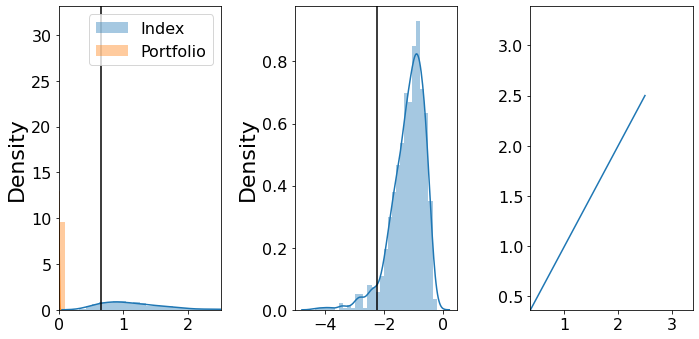

100 Wass Dist: 0.08378081 Risk Measure: -1.1092342 Loss: -0.5546171069145203


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

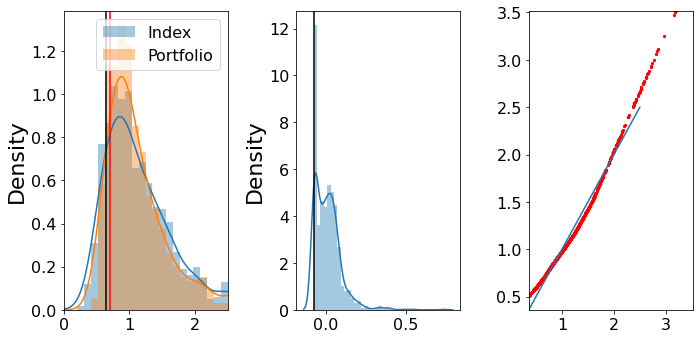

200 Wass Dist: 0.079492904 Risk Measure: -1.0867287 Loss: -0.5433643460273743


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

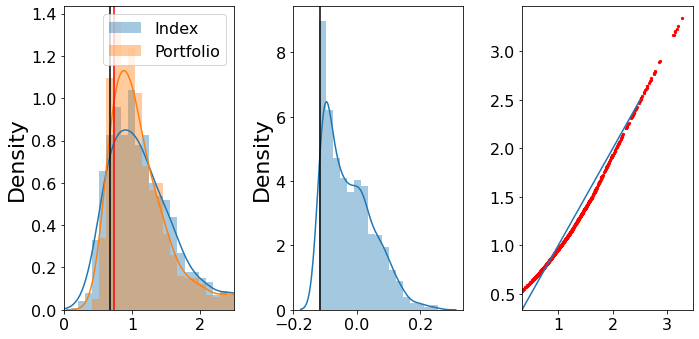

Finished Training


In [18]:
net = MyNet(50).to(device)
RiskMeasure, wass_dist, X_t, Y_t = SimRM(net, params, Nsims=1000, device=device)
PlotHists(X_t, Y_t)

# create  optimizer
optimizer = optim.Adam(net.parameters())

Nepochs = 300
loss_hist = []
risk_history = []
wass_dist_history=[]

for epoch in range(Nepochs):  # loop over the dataset multiple times


    # zero the parameter gradients
    optimizer.zero_grad()

    RiskMeasure, wass_dist,  X_t, Y_t = SimRM(net, params, Nsims=1000, device=device)
    
    
    # loss = 10*wass_dist*(wass_dist>0.1) \
    #     + RiskMeasure/2 \
    #     + 10*(torch.mean(Y_t)>torch.mean(X_t))
     
    loss = 10*wass_dist*(wass_dist>0.1) \
        + RiskMeasure/2 

    loss.backward()   
    
    optimizer.step()
    
    # store running loss
    loss_hist.append(  loss.item() )
    risk_history.append( RiskMeasure.cpu().detach().numpy() )
    wass_dist_history.append( wass_dist.cpu().detach().numpy() )
    
    # PlotHists(X_t, Y_t)
    
    # plot output every 50 iterations
    if( (epoch % 100 == 0) and (epoch>1) ):
        print(epoch, end=" ")
        print("Wass Dist:", wass_dist.cpu().detach().numpy(), end=" " )
        print("Risk Measure:", RiskMeasure.cpu().detach().numpy(), end=" ")
        print("Loss:", loss.item())

        PlotHists(X_t, Y_t)
        
        # plt.figure(figsize=(10,5))
        
        # plt.subplot(1,3,1)
        # plt.plot(risk_history)
        # plt.title("RM") 
        
        # plt.subplot(1,3,2)
        # plt.plot(wass_dist_history)
        # plt.title("WD") 
        
        # plt.subplot(1,3,3)
        # plt.plot(loss_hist)
        # plt.title("Loss") 

        # plt.tight_layout()        
        # plt.show()
        

print('Finished Training')

In [19]:
T = 5
Ndt=500
t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  
#set_trace()
# initial investment amount
X0 = 1

num_asset = S.shape[2]
dt = t[1]-t[0]

# don't think we need sensitivities w.r.t. this as they are fixed per simulation
S_t = torch.tensor(S, dtype=torch.float, requires_grad=False, device=device)



x=np.zeros((Ndt+1, Nsims, 2))   
#set_trace()

  

S_Ret = (S_t[1:,:,:]-S_t[:-1,:,:])/S_t[:-1,:,:]

#Benchmark Delta and return
Delta_t = torch.zeros((Ndt, Nsims, num_asset), \
                              dtype=torch.float, requires_grad=False, device=device)
# note only 90% invested in risky assets here... 10% in risk-free
delta = torch.tensor(params["delta"],requires_grad=False, device=device)
delta_r = 1 - torch.sum(delta)
Delta_t += delta 

# accumulate returns as we go along
Benchmark_Ret = delta_r * params["rf"] * dt+ torch.sum(Delta_t * S_Ret , axis=2)

BenchmarkVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)
BenchmarkVal_path[0,:]  = X0
BenchmarkVal_path[1:,:] = X0*torch.cumprod( (1.0+Benchmark_Ret), axis=0)
BenchmarkVal_T = BenchmarkVal_path[-1,:].reshape(-1,1)
#print(torch.mean(BenchmarkVal_path,1))
#
# Getting the portfolio weights using benchmark value and time as features
#
x=np.zeros((Ndt+1, Nsims, 2))   
#set_trace()

x[:,:,0] = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)
xt = torch.tensor(x, dtype=torch.float, device=device)

xt[:,:,1] = BenchmarkVal_path/X0
xt.shape

torch.Size([501, 1000, 2])

In [20]:
wt = net(xt) 

In [21]:
x[:,:,0] 

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.004, 0.004, 0.004, ..., 0.004, 0.004, 0.004],
       ...,
       [0.996, 0.996, 0.996, ..., 0.996, 0.996, 0.996],
       [0.998, 0.998, 0.998, ..., 0.998, 0.998, 0.998],
       [1.   , 1.   , 1.   , ..., 1.   , 1.   , 1.   ]])

In [22]:
# the candidate portolio
Portfolio_Ret = (1-torch.sum(wt[:-1,:,:], axis=2)) * params["rf"] * dt+ torch.sum(wt[:-1,:,:] * S_Ret , axis=2)

PortfolioVal_path = torch.zeros((Ndt+1,Nsims), dtype=torch.float, requires_grad=False, device=device)    
PortfolioVal_path[0,:] = X0
PortfolioVal_path[1:,:] = X0*torch.cumprod( (1.0+Portfolio_Ret), axis=0)
PortfolioVal_T = PortfolioVal_path[-1,:].reshape(-1,1)

In [23]:
w_T = wt[-1,:].reshape(-1,1)

In [24]:
PortfolioVal_T.shape

torch.Size([1000, 1])

In [25]:
PortfolioVal_path.shape

torch.Size([501, 1000])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 5.0)

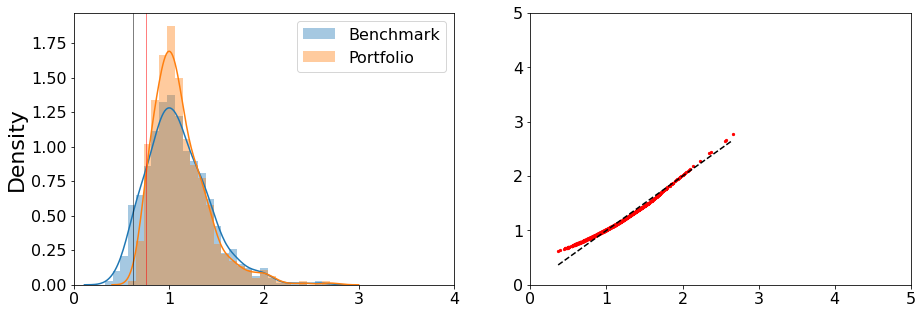

In [26]:
Xcp = BenchmarkVal_T.clone().cpu().detach().numpy()
Ycp = w_T.clone().cpu().detach().numpy()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
bins = np.linspace(0,4,50)

sns.distplot(Xcp, hist=True, kde=True,  bins=bins, label='Benchmark')
sns.distplot(Ycp,  hist=True, kde=True, bins=bins, label='Portfolio')  

plt.axvline(np.quantile(Xcp, 0.05),color='k',linewidth=0.5)
plt.axvline(np.quantile(Ycp, 0.05),color='r',linewidth=0.5)

plt.legend()
plt.xlim(0,4)

plt.subplot(1,2,2)
xs = [min(Xcp), max(Xcp)]
plt.plot(xs,xs,'--k' )
plt.scatter(Xcp,Ycp, marker='o',color='r', s=5)
plt.xlim(0,5)
plt.ylim(0,5)

In [27]:
RiskMeasure = GetRiskMeasure(PortfolioVal_T, "alpha-beta") 
RiskMeasure

tensor(-1.0511, device='cuda:0', grad_fn=<DivBackward0>)

In [28]:
RiskMeasure_Benchmark = GetRiskMeasure(BenchmarkVal_T, "alpha-beta") 
RiskMeasure_Benchmark

tensor(-0.8987, device='cuda:0')

In [51]:
t, S = SimPath(Ndt, params, T=T, Nsims=Nsims)  

In [53]:
t_2 = np.matlib.repmat(t.reshape(-1,1)/t[-1], 1, Nsims)

In [56]:
t_2

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.004, 0.004, 0.004, ..., 0.004, 0.004, 0.004],
       ...,
       [0.996, 0.996, 0.996, ..., 0.996, 0.996, 0.996],
       [0.998, 0.998, 0.998, ..., 0.998, 0.998, 0.998],
       [1.   , 1.   , 1.   , ..., 1.   , 1.   , 1.   ]])

In [44]:
X_2 = np.linspace(0.5, 3, 1000)

In [47]:
x1_n, x2_n = np.meshgrid(X_2,t_2)

In [50]:
x2_n.shape

(100000, 1000)

Text(0.5, 0, 'x')

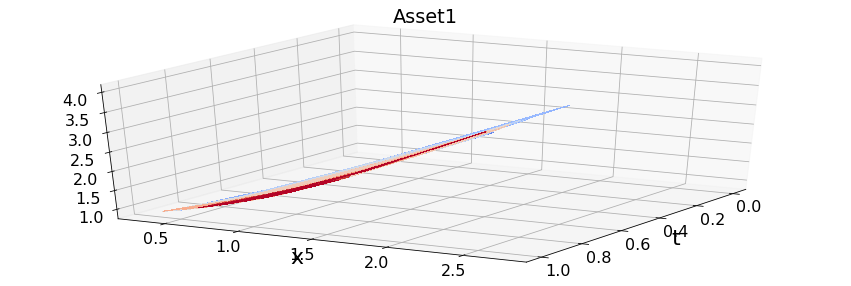

In [55]:
from matplotlib import cm
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#Normalizing the weights to get the ratio of portfolio and benchmark weight
ax.plot_surface(t_2, BenchmarkVal_path.cpu().detach().numpy(), wt[:,:,0].cpu().detach().numpy()/params["delta"][0], cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.view_init(30, 30)

plt.title('Asset' + str(i+1))

plt.xlabel('t')
plt.ylabel('x')

In [58]:
t = np.linspace(0, 1, 100)
X_delta_t = np.linspace(0, 3, 100)
  
x1, x2 = np.meshgrid(X_delta_t, t)

x = np.zeros((x1.shape[0], x1.shape[1], 2))

In [59]:
x2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01010101, 0.01010101, 0.01010101, ..., 0.01010101, 0.01010101,
        0.01010101],
       [0.02020202, 0.02020202, 0.02020202, ..., 0.02020202, 0.02020202,
        0.02020202],
       ...,
       [0.97979798, 0.97979798, 0.97979798, ..., 0.97979798, 0.97979798,
        0.97979798],
       [0.98989899, 0.98989899, 0.98989899, ..., 0.98989899, 0.98989899,
        0.98989899],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

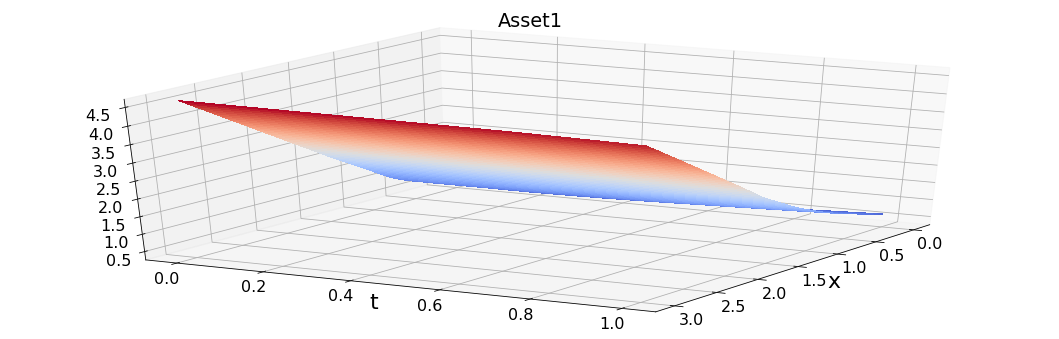

In [66]:

def PlotStrat(net, device):
    
    t = np.linspace(0, 1, 100)
    X_delta_t = np.linspace(0.0, 3, 100)
     
    x1, x2 = np.meshgrid(X_delta_t, t)
    
    x = np.zeros((x1.shape[0], x1.shape[1], 2))
    
    x[:,:,0] = x2
    x[:,:,1] = x1
    
    x_t = torch.tensor(x, dtype=torch.float, device=device )
    
    w_t = net(x_t).cpu().detach().numpy()
        
    fig = plt.figure(figsize=(15,5))

    #params["delta"]
    
    for i in range(w_t.shape[2]):
            
        ax = fig.add_subplot(1, w_t.shape[2], i+1, projection='3d')
        #Normalizing the weights to get the ratio of portfolio and benchmark weight
        ax.plot_surface(x1, x2, w_t[:,:,0]/params["delta"][0], cmap=cm.coolwarm, linewidth=0, antialiased=False)
        
        ax.view_init(30, 30)
        
        plt.title('Asset' + str(i+1))
        
        plt.xlabel('x')
        plt.ylabel('t')
    
    plt.tight_layout()
    plt.show()

PlotStrat(net, device)